In [1]:
sc = SparkContext.getOrCreate()

In [2]:
#1.a

import re
import datetime
from pyspark.sql import Row
month_map = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}

def parse_apache_time(s):
    return datetime.datetime(int(s[7:11]),
                    month_map[s[3:6]],
                    int(s[0:2]),
                    int(s[12:14]),
                    int(s[15:17]),
                    int(s[18:20]))

def parseApacheLogLine(logline):
    match=re.search(APACHE_ACCESS_LOG_PATTERN, logline)
    if match is None:
        return (logline, 0)
    size_field = match.group(9)
    if size_field =='-':
        size = long(0)
    else:
        size = long(match.group(9))
    return (Row(host = match.group(1),
                client_identd = match.group(2),
                user_id = match.group(3),
                date_time = parse_apache_time(match.group(4)),
                method = match.group(5),
                endpoint = match.group(6),
                protocol = match.group(7),
                response_code = int(match.group(8)),
                content_size = size), 1)

APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)" (\d{3}) (\S+)'


In [3]:
# 1.b

logFile = "NASAlog.txt"

def parseLogs():
    parsed_logs = (sc.textFile(logFile).map(parseApacheLogLine).cache())
    
    access_logs = (parsed_logs.filter(lambda s:s[1] == 1).map(lambda s:s[0]).cache())
    
    failed_logs = (parsed_logs.filter(lambda s:s[1]== 0).map(lambda s:s[0]))
    
    failed_logs_count = failed_logs.count()
    if failed_logs_count>0:
        print 'Number of invalid logline:%d'%failed_logs.count()
        for line in failed_logs.take(20):
            print 'invalid logline:%s'%line
            
    print 'Read %d lines, successfully parsed %d lines, failed to parse %d lines'%(parsed_logs.count(), access_logs.count(),
                                                                                   failed_logs.count())
    return parsed_logs, access_logs, failed_logs

parsed_logs, access_logs, failed_logs = parseLogs()

Number of invalid logline:58
invalid logline:wxs6-7.worldaccess.nl - - [02/Jul/1995:08:09:27 -0400] "GET / /   HTTP/1.0" 200 7074
invalid logline:wxs6-7.worldaccess.nl - - [02/Jul/1995:08:11:20 -0400] "GET / /facts/facts.html HTTP/1.0" 200 7074
invalid logline:s29.abqslip.indirect.com - - [02/Jul/1995:14:24:26 -0400] "GET /htbin/wais.pl?Wake Shield HTTP/1.0" 200 7020
invalid logline:pipe3.nyc.pipeline.com - - [02/Jul/1995:22:24:41 -0400] "GET /shuttle/countdown/dy �?shuttle%20tracking HTTP/1.0" 404 -
invalid logline:pipe3.nyc.pipeline.com - - [02/Jul/1995:22:25:48 -0400] "GET /shuttle/countdown/dy �?tracking%20station HTTP/1.0" 404 -
invalid logline:wxs6-4.worldaccess.nl - - [03/Jul/1995:08:14:40 -0400] "GET / /   HTTP/1.0" 304 0
invalid logline:atl4-m52.ed.ac.uk - - [03/Jul/1995:09:31:12 -0400] "GET /images/NASA-logosmall.gif align=left HTTP/1.0" 200 786
invalid logline:atl4-m52.ed.ac.uk - - [03/Jul/1995:09:32:20 -0400] "GET /images/NASA-logosmall.gif align=left HTTP/1.0" 200 786
inva

In [4]:
# 1.c

APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+).*\[([\w:\/]+\s[+\-]\d{4})\] "(\S+) (\S*)( *\S+ *)*" (\d{3}) (\S+)'

parsed_logs, access_logs, failed_logs = parseLogs()


print failed_logs.count()

print parsed_logs.count()

print access_logs.count()

Read 314876 lines, successfully parsed 314876 lines, failed to parse 0 lines
0
314876
314876


In [5]:
# 2.a

content_sizes = access_logs.map(lambda log: log.content_size).cache()
print 'Content Size Avg: %i, Min: %i, Max: %s' % (
content_sizes.reduce(lambda a, b : a + b) / content_sizes.count(),
content_sizes.min(),
content_sizes.max())

Content Size Avg: 23542, Min: 0, Max: 2973350


In [6]:
# 2.b

responseCodeToCount = (access_logs
.map(lambda log: (log.response_code, 1))
.reduceByKey(lambda a, b : a + b)
.cache())
responseCodeToCountList = responseCodeToCount.take(100)
print 'Found %d response codes' % len(responseCodeToCountList)
print 'Response Code Counts: %s' % responseCodeToCountList

Found 7 response codes
Response Code Counts: [(200, 283992), (304, 17842), (404, 1621), (500, 53), (302, 11354), (403, 13), (501, 1)]


[200, 304, 404, 500, 302, 403, 501]
[0.9019169450831438, 0.05666357550273759, 0.005148058283260712, 0.00016832022764516825, 0.03605863895628755, 4.1286093573343156e-05, 3.1758533517956276e-06]


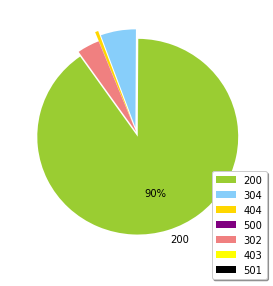

In [7]:
# 2.c

labels = responseCodeToCount.map(lambda (x, y): x).collect()
print labels
count = access_logs.count()
fracs = responseCodeToCount.map(lambda (x, y): (float(y) / count)).collect()
print fracs

import matplotlib.pyplot as plt
def pie_pct_format(value):
    return '' if value < 7 else '%.0f%%' % value

fig = plt.figure(figsize=(4.5, 4.5), facecolor='white', edgecolor='white')
colors = ['yellowgreen', 'lightskyblue', 'gold', 'purple', 'lightcoral', 'yellow', 'black']
explode = (0.05, 0.05, 0.1, 0, 0, 0, 0)
patches, texts, autotexts = plt.pie(fracs, labels=labels, colors=colors,
explode=explode, autopct=pie_pct_format,
shadow=False, startangle=125)

for text, autotext in zip(texts, autotexts):
    if autotext.get_text() == '':
        text.set_text('') # If the slice is small to fit, don't show a text label
plt.legend(labels, loc=(0.80, -0.1), shadow=True)
display(fig)

In [8]:
# 2.d

hostCountPairTuple = access_logs.map(lambda log: (log.host, 1))
hostSum = hostCountPairTuple.reduceByKey(lambda a, b : a + b)
hostMoreThan10 = hostSum.filter(lambda s: s[1] > 10)
hostsPick20 = (hostMoreThan10
.map(lambda s: s[0])
.take(20))
print 'Any 20 hosts that have accessed more then 10 times: %s' % hostsPick20

Any 20 hosts that have accessed more then 10 times: [u'sos.wingham.com', u'151.114.64.64', u'dial-224.locm.dial.peach.net', u'134.134.192.7', u'ip16-029.phx.primenet.com', u'martym.space.swri.edu', u'libed-10.union.utah.edu', u'gs1.cs.ttu.edu', u'ruger-93.slip.uiuc.edu', u'dcn60.dcn.davis.ca.us', u'ppp3_207.bekkoame.or.jp', u'slip1-25.acs.ohio-state.edu', u'ad15-014.compuserve.com', u'skyblu.ccit.arizona.edu', u'bib7.bc.edu', u'hot12.cait.wustl.edu', u'd307.sth.pi.se', u'osip90.ionet.net', u'penang.sfc.keio.ac.jp', u'gbms01.uwgb.edu']


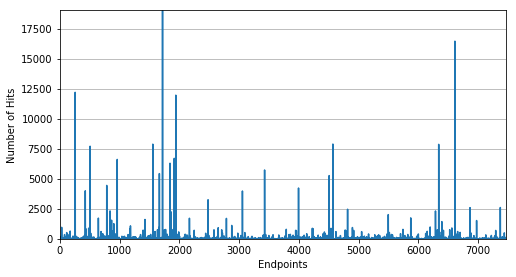

In [9]:
# 2.e

endpoints = (access_logs
.map(lambda log: (log.endpoint, 1))
.reduceByKey(lambda a, b : a + b)
.cache())
ends = endpoints.map(lambda (x, y): x).collect()
counts = endpoints.map(lambda (x, y): y).collect()
fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, len(ends), 0, max(counts)])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Endpoints')
plt.ylabel('Number of Hits')
plt.plot(counts)
display(fig)

In [10]:
# 2.f

endpointCounts = (access_logs
.map(lambda log: (log.endpoint, 1))
.reduceByKey(lambda a, b : a + b))
topEndpoints = endpointCounts.takeOrdered(10, lambda s: -1 * s[1])
print 'Top Ten Endpoints: %s' % topEndpoints

Top Ten Endpoints: [(u'/images/NASA-logosmall.gif', 19065), (u'/images/KSC-logosmall.gif', 16502), (u'/shuttle/countdown/count.gif', 12230), (u'/shuttle/countdown/', 11992), (u'/images/MOSAIC-logosmall.gif', 7912), (u'/images/ksclogo-medium.gif', 7902), (u'/images/USA-logosmall.gif', 7887), (u'/images/WORLD-logosmall.gif', 7729), (u'/shuttle/missions/sts-71/images/images.html', 6718), (u'/shuttle/missions/sts-71/sts-71-patch-small.gif', 6628)]


In [11]:
# 3.a

not200 = access_logs.filter(lambda log: log.response_code != 200)
endpointCountPairTuple = not200.map(lambda log: (log.endpoint, 1))
endpointSum = endpointCountPairTuple.reduceByKey(lambda a,b: (a+b))
topTenErrURLs = endpointSum.takeOrdered(10, lambda s: -1 * s[1])
print endpointSum.count()

print 'Top Ten failed URLs: %s' % topTenErrURLs

4690
Top Ten failed URLs: [(u'/images/NASA-logosmall.gif', 2404), (u'/images/KSC-logosmall.gif', 1806), (u'/shuttle/countdown/', 944), (u'/images/MOSAIC-logosmall.gif', 845), (u'/images/USA-logosmall.gif', 830), (u'/images/WORLD-logosmall.gif', 811), (u'/shuttle/countdown/count.gif', 777), (u'/images/ksclogo-medium.gif', 751), (u'/shuttle/countdown/liftoff.html', 590), (u'/shuttle/missions/sts-71/sts-71-patch-small.gif', 543)]


In [12]:
# 3.b

hosts = access_logs.map(lambda log: log.host)
uniqueHosts = hosts.distinct()
uniqueHostCount = uniqueHosts.count()
print 'Unique hosts: %d' % uniqueHostCount

Unique hosts: 22013


In [13]:
# 3.c

dayToHostPairTuple = access_logs.map(lambda log: (log.date_time.day, log.host))
dayGroupedHosts = dayToHostPairTuple.groupByKey()
dayHostCount = dayGroupedHosts.map(lambda pair: (pair[0], len(set(pair[1]))))
dailyHosts = (dayHostCount.sortByKey().cache())
dailyHostsList = dailyHosts.takeOrdered(4)
print 'Unique hosts per day: %s' % dailyHostsList
dailyHosts.cache()

Unique hosts per day: [(2, 4859), (3, 7336), (4, 5524), (5, 7383)]


PythonRDD[74] at RDD at PythonRDD.scala:48

[2, 3, 4, 5]
[4859, 7336, 5524, 7383]


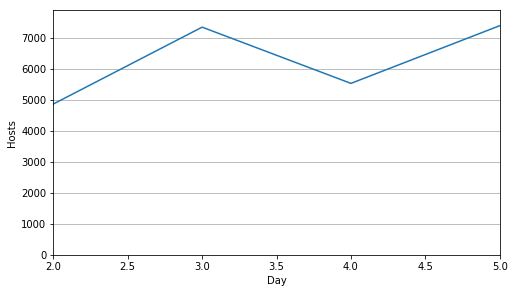

In [15]:
# 3.d

daysWithHosts = dailyHosts.map(lambda (x,y): x).collect()
hosts = dailyHosts.map(lambda (x,y): y).collect()
print daysWithHosts

print hosts
fig = plt.figure(figsize=(8,4.5), facecolor='white', edgecolor='white')
plt.axis([min(daysWithHosts), max(daysWithHosts), 0, max(hosts)+500])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Day')
plt.ylabel('Hosts')
plt.plot(daysWithHosts, hosts)
display(fig)

In [17]:
# 3.e

dayAndHostTuple = access_logs.map(lambda log: (log.date_time.day, log.host))
groupedByDay = dayAndHostTuple.groupByKey()
sortedByDay = groupedByDay.sortByKey()
avgDailyReqPerHost = (sortedByDay.map(lambda x: (x[0], len(x[1])/len(set(x[1])))).cache())
avgDailyReqPerHostList = avgDailyReqPerHost.take(4)
print 'Average number of daily requests per Hosts is %s' % avgDailyReqPerHostList

avgDailyReqPerHost.cache()

Average number of daily requests per Hosts is [(2, 12), (3, 12), (4, 12), (5, 12)]


PythonRDD[90] at RDD at PythonRDD.scala:48

[2, 3, 4, 5]
[12, 12, 12, 12]


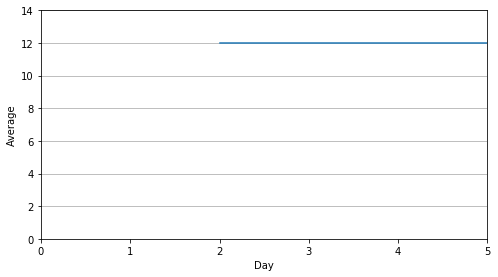

In [18]:
# 3.f

daysWithAvg = avgDailyReqPerHost.map(lambda (x,y): x).collect()
avgs = avgDailyReqPerHost.map(lambda (x,y): y).collect()
print daysWithAvg

print avgs

fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, max(daysWithAvg), 0, max(avgs)+2])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Day')
plt.ylabel('Average')
plt.plot(daysWithAvg, avgs)
display(fig)

In [22]:
# 4.a

badRecords = (access_logs.filter(lambda x: x.response_code == 404))
print 'Found %d 404 URLs' % badRecords.count()

badRecords.cache()

Found 1621 404 URLs


PythonRDD[102] at RDD at PythonRDD.scala:48

In [25]:
# 4.b

badEndpoints = badRecords.map(lambda x: x.endpoint)
badUniqueEndpoints = badEndpoints.distinct()
badUniqueEndpointsPick40 = badUniqueEndpoints.takeOrdered(40)
print '404 URLS: %s' % badUniqueEndpointsPick40

print len(set(badUniqueEndpointsPick40))

404 URLS: [u'/%3A//spacelink.msfc.nasa.gov', u'/%7Eadverts/ibm/ad1/banner.gif', u'//history/apollo/apollo-13/apollo-13html', u'//spacelink.msfc.nasa.gov/', u'//spacelink.msfc.nasa.gov:70/00/About.Spacelink/File.Transfer.Protocols', u'/11/history/apollo/images/', u'/://spacelink.msfc.nasa.gov', u'/:/spacelink.msfc.nasa.gov', u'/DataSources/MetData.html', u'/Government/Research_Labs/NASA/Kennedy_Space_Center/', u'/HISTOTY/APOLLO/APOLLO-13/', u'/KSC.', u'/KSC.HTML', u'/KSC.HTML/', u'/LDAR/LDARhp.html', u'/NASA_TV/NASA_TV.html', u'/SDG/Experimental/demoweb/return.gif', u'/SHUTTLE', u'/SHUTTLE/COUNTDOWN/', u'/SHUTTLE/MISSION/STS-71/IMAGES/IMAGES.HTML', u'/SHUTTLE/MISSIONS/STS-71/IMAGES/IMAGES.HTML', u'/Science/Space/Missions/Magellan_Mission_to_Venus/', u'/Tools/Bars/Front/main_bar.gif', u'/Tools/Icons/Help/hw.embossed.grey.gif', u'/apollo-13.html', u'/att.net/dir800/', u'/bann04.gif', u'/base-ops/procurement/kscbus.htm', u'/bigspot.com', u'/cleve.net/cnnavbar.gif', u'/daily/ecs/s71e0003.jp

In [26]:
# 4.c

badEndpointsCountPairTuple = badRecords.map(lambda x:(x.endpoint, 1)).reduceByKey(lambda a, b: (a+b))
badEndpointsSum = badEndpointsCountPairTuple.sortBy(lambda x: x[1], False)
badEndpointsTop20 = badEndpointsSum.take(20)
print 'Top Twenty 404 URLs: %s' % badEndpointsTop20


Top Twenty 404 URLs: [(u'/pub/winvn/readme.txt', 84), (u'/pub/winvn/release.txt', 82), (u'/history/apollo/publications/sp-350/sp-350.txt~', 67), (u'/shuttle/resources/orbiters/atlantis.gif', 65), (u'/shuttle/missions/sts-71/images/KSC-95EC-0916.txt', 55), (u'/://spacelink.msfc.nasa.gov', 47), (u'/history/apollo/a-001/a-001-patch-small.gif', 46), (u'/history/apollo/pad-abort-test-1/pad-abort-test-1-patch-small.gif', 44), (u'/history/apollo/sa-1/sa-1-patch-small.gif', 42), (u'/history/apollo/apollo-13.html', 36), (u'/images/crawlerway-logo.gif', 31), (u'/shuttle/missions/sts-68/ksc-upclose.gif', 29), (u'/histroy/apollo-13/apollo-13.html', 20), (u'/history/apollo/sa-9/sa-9-patch-small.gif', 19), (u'/shuttle/missions/technology/sts-newsref/stsref-toc.html', 19), (u'/shuttle/resources/orbiters/challenger.gif', 18), (u'/shuttle/technology/images/tps_mods-small.gif', 14), (u'/history/apollo/images/little-joe.jpg', 13), (u'/persons/astronauts/a-to-d/conradCC.txt', 12), (u'/pub', 12)]


In [27]:
# 4.d

errHostsCountPairTuple = badRecords.map(lambda x: (x.host, 1)).reduceByKey(lambda a,b: (a+b))
errHostsSum = errHostsCountPairTuple.sortBy(lambda x: x[1], False)
errHostsTop25 = errHostsSum.take(25)
print 'Top 25 hosts that generated errors: %s' % errHostsTop25

Top 25 hosts that generated errors: [(u'piweba3y.prodigy.com', 29), (u'128.158.48.26', 26), (u'espresso.sd.inri.com', 25), (u'www-b6.proxy.aol.com', 22), (u'ch025.chance.berkeley.edu', 17), (u'www-d4.proxy.aol.com', 15), (u'ffong-sl.cc.emory.edu', 15), (u'alyssa.prodigy.com', 14), (u'cpcug.org', 14), (u'advantis.vnet.ibm.com', 13), (u'128.158.32.107', 12), (u'sta07.oit.unc.edu', 12), (u'dialup-2-89.gw.umn.edu', 11), (u'www-b5.proxy.aol.com', 11), (u'www-d1.proxy.aol.com', 10), (u'ten-nash.ten.k12.tn.us', 10), (u'dd13-025.compuserve.com', 10), (u'w20-575-4.mit.edu', 10), (u'disc.dna.affrc.go.jp', 9), (u'ix-bal2-14.ix.netcom.com', 9), (u'wstabnow.gsfc.nasa.gov', 9), (u'www-b1.proxy.aol.com', 8), (u'dawn14.cs.berkeley.edu', 8), (u'gatekeeper.mitre.org', 8), (u'204.64.145.73', 8)]


In [28]:
# 4.e

errDateCountPairTuple = badRecords.map(lambda x: (x.date_time.day, 1))
errDateSum = errDateCountPairTuple.reduceByKey(lambda a,b: (a+b))
errDateSorted = (errDateSum.sortByKey())
errByDate = errDateSorted.collect()
print '404 Errors by day: %s' % errByDate
errDateSorted.cache()

404 Errors by day: [(2, 291), (3, 474), (4, 359), (5, 497)]


PythonRDD[150] at collect at <ipython-input-28-283ea2e8757c>:6

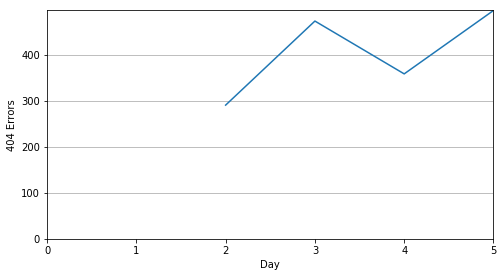

In [29]:
# 4.f

daysWithErrors404 = errDateSorted.keys().collect()
errors404ByDay = errDateSorted.values().collect()
fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, max(daysWithErrors404), 0, max(errors404ByDay)])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Day')
plt.ylabel('404 Errors')
plt.plot(daysWithErrors404, errors404ByDay)
display(fig)

In [36]:
# 4.g

hourCountPairTuple = badRecords.map(lambda log:(log.date_time.hour, 1))
hourRecordsSum = hourCountPairTuple.reduceByKey(lambda a,b: a+b)
hourRecordsSorted = (hourRecordsSum.sortByKey())
errHourList = hourRecordsSorted.collect()
print '404 Errors by hour: %s' % errHourList

hourRecordsSorted.cache()

404 Errors by hour: [(0, 72), (1, 77), (2, 37), (3, 30), (4, 13), (5, 22), (6, 26), (7, 42), (8, 72), (9, 104), (10, 64), (11, 68), (12, 69), (13, 52), (14, 98), (15, 99), (16, 121), (17, 76), (18, 101), (19, 54), (20, 58), (21, 52), (22, 73), (23, 141)]


PythonRDD[174] at collect at <ipython-input-36-fbedbe9c9469>:6

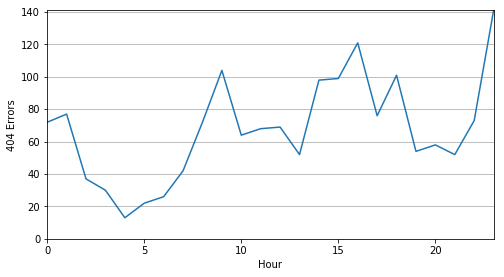

In [37]:
# 4.h

hoursWithErrors404 = hourRecordsSorted.keys().collect()
errors404ByHours = hourRecordsSorted.values().collect()
fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, max(hoursWithErrors404), 0, max(errors404ByHours)])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Hour')
plt.ylabel('404 Errors')
plt.plot(hoursWithErrors404, errors404ByHours)
display(fig)